In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import torch

torch.cuda.empty_cache()

In [3]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [4]:
df_en_train = pd_read_jsonl_file('../data/en_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/en_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/en_devtest_text_id_only.jsonl')

In [5]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610767 entries, 0 to 610766
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          610767 non-null  object
 1   source      610767 non-null  object
 2   sub_source  610767 non-null  object
 3   lang        610767 non-null  object
 4   model       610767 non-null  object
 5   label       610767 non-null  int64 
 6   text        610767 non-null  object
dtypes: int64(1), object(6)
memory usage: 32.6+ MB


In [6]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


# Load model

In [7]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [9]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [17]:
human_train_sample_text = df_en_train[df_en_train["label"] == 0]["text"].tolist()[0]
human_train_sample_label = df_en_train[df_en_train["label"] == 0]["label"].tolist()[0]

In [23]:
from nltk import sent_tokenize

human_train_sample_text_sentences = sent_tokenize(human_train_sample_text)

In [19]:
human_train_sample_text

'The Bush administration then turned its attention to Iraq, and argued the need to remove Saddam Hussein from power in Iraq had become urgent. Among the stated reasons were that Saddam\'s regime had tried to acquire nuclear material and had not properly accounted for biological and chemical material it was known to have previously possessed, and believed to still maintain. Both the possession of these weapons of mass destruction (WMD), and the failure to account for them, would violate the U.N. sanctions. The assertion about WMD was hotly advanced by the Bush administration from the beginning, but other major powers including China, France, Germany, and Russia remained unconvinced that Iraq was a threat and refused to allow passage of a UN Security Council resolution to authorize the use of force. Iraq permitted UN weapon inspectors in November 2002, who were continuing their work to assess the WMD claim when the Bush administration decided to proceed with war without UN authorization 

In [25]:
human_train_sample_text_sentences

['The Bush administration then turned its attention to Iraq, and argued the need to remove Saddam Hussein from power in Iraq had become urgent.',
 "Among the stated reasons were that Saddam's regime had tried to acquire nuclear material and had not properly accounted for biological and chemical material it was known to have previously possessed, and believed to still maintain.",
 'Both the possession of these weapons of mass destruction (WMD), and the failure to account for them, would violate the U.N. sanctions.',
 'The assertion about WMD was hotly advanced by the Bush administration from the beginning, but other major powers including China, France, Germany, and Russia remained unconvinced that Iraq was a threat and refused to allow passage of a UN Security Council resolution to authorize the use of force.',
 'Iraq permitted UN weapon inspectors in November 2002, who were continuing their work to assess the WMD claim when the Bush administration decided to proceed with war without U

In [20]:
human_train_sample_label

0

In [18]:
machine_train_sample_text = df_en_train[df_en_train["label"] == 1]["text"].tolist()[0]
machine_train_sample_label = df_en_train[df_en_train["label"] == 1]["label"].tolist()[0]

In [24]:
from nltk import sent_tokenize

machine_train_sample_text_sentences = sent_tokenize(machine_train_sample_text)

In [30]:
machine_train_sample_text_sentences

["Hitler's plans for the succession and power structure after his death are shrouded in mystery, as he never explicitly wrote down his intentions.",
 'However, it is known that he designated several potential successors, including Heinrich Himmler, Hermann Göring, and Joseph Goebbels, each with their own strengths and weaknesses.',
 'In the final days of his life, Hitler grew increasingly paranoid and isolated, leading to rumors of a civil war within the Nazi Party.',
 'He became convinced that the Party was plotting against him, and his trusted advisors, including Goering and Himmler, were secretly vying for power.',
 "To counter this perceived threat, Hitler reportedly planned to appoint a successor, most likely Himmler, in a 'Fuhrer-proof' mechanism.",
 'This would have granted Himmler absolute power over the Party and state, rendering the concept of democratic succession irrelevant.',
 'Hitler also envisioned a hierarchical, hereditary power structure, with his loyal followers and 

In [21]:
machine_train_sample_text

"Hitler's plans for the succession and power structure after his death are shrouded in mystery, as he never explicitly wrote down his intentions. However, it is known that he designated several potential successors, including Heinrich Himmler, Hermann Göring, and Joseph Goebbels, each with their own strengths and weaknesses. \n\nIn the final days of his life, Hitler grew increasingly paranoid and isolated, leading to rumors of a civil war within the Nazi Party. He became convinced that the Party was plotting against him, and his trusted advisors, including Goering and Himmler, were secretly vying for power. \n\nTo counter this perceived threat, Hitler reportedly planned to appoint a successor, most likely Himmler, in a 'Fuhrer-proof' mechanism. This would have granted Himmler absolute power over the Party and state, rendering the concept of democratic succession irrelevant. Hitler also envisioned a hierarchical, hereditary power structure, with his loyal followers and their families ho

In [22]:
machine_train_sample_label

1

In [350]:
def generate_text(model, tokenizer, context, generation_style="sentences", no_of_generated_sentences=2):
    model.eval()

    messages = []

    if generation_style == "sentences":
        messages = [
            {
                "role": "system",
                "content": f"You are an assistant and help people continue their stories with the most relevant information in the most natural way possible. You will have to respond with EXACTLY {no_of_generated_sentences} sentences."
            },
            {
                "role": "user",
                "content": f"Using only {no_of_generated_sentences} sentences continue this story in the most natural way possible: {context}"
            }
        ]
    elif generation_style == "words":
        messages = [
            {
                "role": "system",
                "content": f"You are an assistant and help people finish their sentences with the most relevant information in the most natural way possible. You should only complete the given sentence."
            },
            {
                "role": "user",
                "content": f"Finish this sentence in the most natural way possible: {context}"
            }
        ]
    else:
        raise Exception(f"No such generation_style = {generation_style}")

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=1024,
        )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [66]:
human_train_sample_text_generated = generate_text(
    model,
    tokenizer,
    " ".join(human_train_sample_text_sentences[:-2])
)

In [67]:
machine_train_sample_text_generated = generate_text(
    model,
    tokenizer,
    " ".join(machine_train_sample_text_sentences[:-2])
)

In [58]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer("all-MiniLM-L6-v2")

/root/.conda/envs/pytorch/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [110]:
from sentence_transformers import util

def compute_similarity_score(st_model, original, generated):
    original_embedding = st_model.encode(original)
    generated_embeddings = st_model.encode(generated)
    
    # similarity = st_model.similarity(original_embedding, generated_embeddings)
    similarity = util.pytorch_cos_sim(original_embedding, generated_embeddings).detach().numpy()[0][0]
    return similarity

In [95]:
compute_similarity_score(st_model, " ".join(human_train_sample_text_sentences[-2:]), human_train_sample_text_generated)

0.3775603

In [96]:
compute_similarity_score(st_model, " ".join(machine_train_sample_text_sentences[-2:]), machine_train_sample_text_generated)

0.5917352

In [306]:
from nltk import word_tokenize, sent_tokenize


def generate_and_compute_similarity(model, tokenizer, st_model, text, no_of_sentences=2):
    sentences = sent_tokenize(text)

    n = len(sentences)

    original_text = ""
    generated_text = ""
    
    if n == 1:
        words = word_tokenize(sentences[0])

        # words_split = 2 * (len(words) // 3)
        words_split = len(words) // 2

        original_text = " ".join(words[words_split:])

        context = " ".join(words[:words_split])

        generated_text = generate_text(
            model,
            tokenizer,
            context,
            generation_style="words",
        )

        # original_text = sentences[0]
        # generated_text = f"{context} {generated_text}"
    elif n == 2:
        original_text = sentences[1]

        context = sentences[0]

        generated_text = generate_text(
            model,
            tokenizer,
            context,
            generation_style="sentences",
            no_of_generated_sentences=1,
        )
    else:
        no_of_starting_sentences = 2
        generated_sentences = sentences[:no_of_starting_sentences]
    
        no_of_generated_sentences = min(no_of_sentences, n - no_of_starting_sentences)
        for idx in range(no_of_starting_sentences, n, no_of_generated_sentences):
            context = " ".join(generated_sentences[:idx])
    
            generated = generate_text(
                model,
                tokenizer,
                context,
                generation_style="sentences",
                no_of_generated_sentences=no_of_generated_sentences,
            )
    
            generated_sentences.append(generated)
    
        original_text = " ".join(sentences[no_of_starting_sentences:])
        generated_text = " ".join(generated_sentences[no_of_starting_sentences:])

    # print(f"original_text: {original_text}")
    # print(f"generated_text: {generated_text}")

    similarity_score = compute_similarity_score(
        st_model,
        original_text,
        generated_text,
    )

    return similarity_score

In [248]:
generate_and_compute_similarity(
    model,
    tokenizer,
    st_model,
    df_en_train_small.text.tolist()[0],
)

original_text: the side , away from your body , then bring it back in and repeat on the other side for the desired amount of reps .
generated_text: Keep your core engaged, ensuring a strong foundation for the next movement.


0.33342558

In [243]:
df_en_train_small.label.tolist()[0]

1

In [132]:
df_en_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32557 entries, 0 to 32556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      32557 non-null  object
 1   text    32557 non-null  object
dtypes: object(2)
memory usage: 508.8+ KB


In [325]:
df_en_train_small = df_en_train.sample(100, random_state=RANDOM_SEED, ignore_index=True)

In [326]:
df_en_train_small.head()

,id,source,sub_source,lang,model,label,text
0,71fee829-7871-4d08-9ca4-cb745808559e,mage,hswag,en,gpt-3.5-turbo,1,[Additional step] Slowly lift one foot off the...
1,10ac6396-e03a-4a7e-a53c-a83df2b66f5f,m4gt,wikihow,en,davinci,1,Traveling without overpacking can seem like an...
2,d3562b41-f80c-4036-ba45-c887574a8b68,m4gt,reddit,en,cohere,1,The abolishment of the Caliphate was a major e...
3,98f6758e-41ce-4248-bb17-2b3f147c96d3,mage,squad,en,human,0,Beer ranges from less than 3 alcohol by volume...
4,b6d1c774-5bf9-43a1-9271-81983ead5894,m4gt,wikipedia,en,bloomz,1,Institute of Eastern Europe (IEE) is the large...


In [327]:
df_en_train_small.label.value_counts()

label
1    62
0    38
Name: count, dtype: int64

In [328]:
from tqdm import tqdm

tqdm.pandas()

# Use the model to generate last 4 sentences and compute similarity score
df_en_train_small['similarity_score'] = df_en_train_small['text'].progress_apply(
    lambda text: generate_and_compute_similarity(model, tokenizer, st_model, text, no_of_sentences=2)
)

100%|██████████| 100/100 [10:47<00:00,  6.48s/it]


In [329]:
df_en_train_small["no_of_sentences"] = df_en_train_small["text"].map(lambda text: len(sent_tokenize(text)))

In [335]:
df_en_train_small["label_based_on_similarity"] = df_en_train_small["similarity_score"].map(lambda score: 1 if score > 0.7 else 0)

In [331]:
df_en_train_small

,id,source,sub_source,lang,model,label,text,similarity_score,no_of_sentences,label_based_on_similarity
0,71fee829-7871-4d08-9ca4-cb745808559e,mage,hswag,en,gpt-3.5-turbo,1,[Additional step] Slowly lift one foot off the...,0.509873,1,1
1,10ac6396-e03a-4a7e-a53c-a83df2b66f5f,m4gt,wikihow,en,davinci,1,Traveling without overpacking can seem like an...,0.657476,23,1
2,d3562b41-f80c-4036-ba45-c887574a8b68,m4gt,reddit,en,cohere,1,The abolishment of the Caliphate was a major e...,0.837168,15,1
3,98f6758e-41ce-4248-bb17-2b3f147c96d3,mage,squad,en,human,0,Beer ranges from less than 3 alcohol by volume...,0.469563,5,0
4,b6d1c774-5bf9-43a1-9271-81983ead5894,m4gt,wikipedia,en,bloomz,1,Institute of Eastern Europe (IEE) is the large...,0.168207,2,0
...,...,...,...,...,...,...,...,...,...,...
95,ad05076b-eef9-4f9a-881f-9c4fe985dd30,m4gt,reddit,en,human,0,Kind of general understanding is that if you w...,0.630675,12,1
96,84ce48d0-f693-47a2-b479-cd7e51e15150,m4gt,reddit,en,human,0,Iranian Politics are a bit complicated and con...,0.681570,19,1
97,c84db1fd-8acc-4ccc-8132-314a71213ba2,mage,cmv,en,flan_t5_small,1,Final Edit: Thank you to everyone who contribu...,0.089615,4,0
98,d1462304-e595-41e6-82fe-94d60d5e485d,m4gt,wikipedia,en,gemma-7b-it,1,## 1896 Boston Beaneaters Season\n\nThe 1896 B...,0.726952,19,1


In [336]:
# predictions = df_en_train_small[df_en_train_small["no_of_sentences"] == 1]["label_based_on_similarity"].tolist()
# labels = df_en_train_small[df_en_train_small["no_of_sentences"] == 1]["label"].tolist()

# predictions = df_en_train_small[df_en_train_small["no_of_sentences"] > 1]["label_based_on_similarity"].tolist()
# labels = df_en_train_small[df_en_train_small["no_of_sentences"] > 1]["label"].tolist()

predictions = df_en_train_small["label_based_on_similarity"].tolist()
labels = df_en_train_small["label"].tolist()

macro_f1 = f1_score(predictions, labels, average='macro')
accuracy = accuracy_score(predictions,labels)
balanced_accuracy = balanced_accuracy_score(predictions, labels)

print(f"F1: {macro_f1}")
print(f"Accuracy: {accuracy}")
print(f"Balanced accuracy: {balanced_accuracy}")

F1: 0.5422642660970399
Accuracy: 0.55
Balanced accuracy: 0.6466666666666666


/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


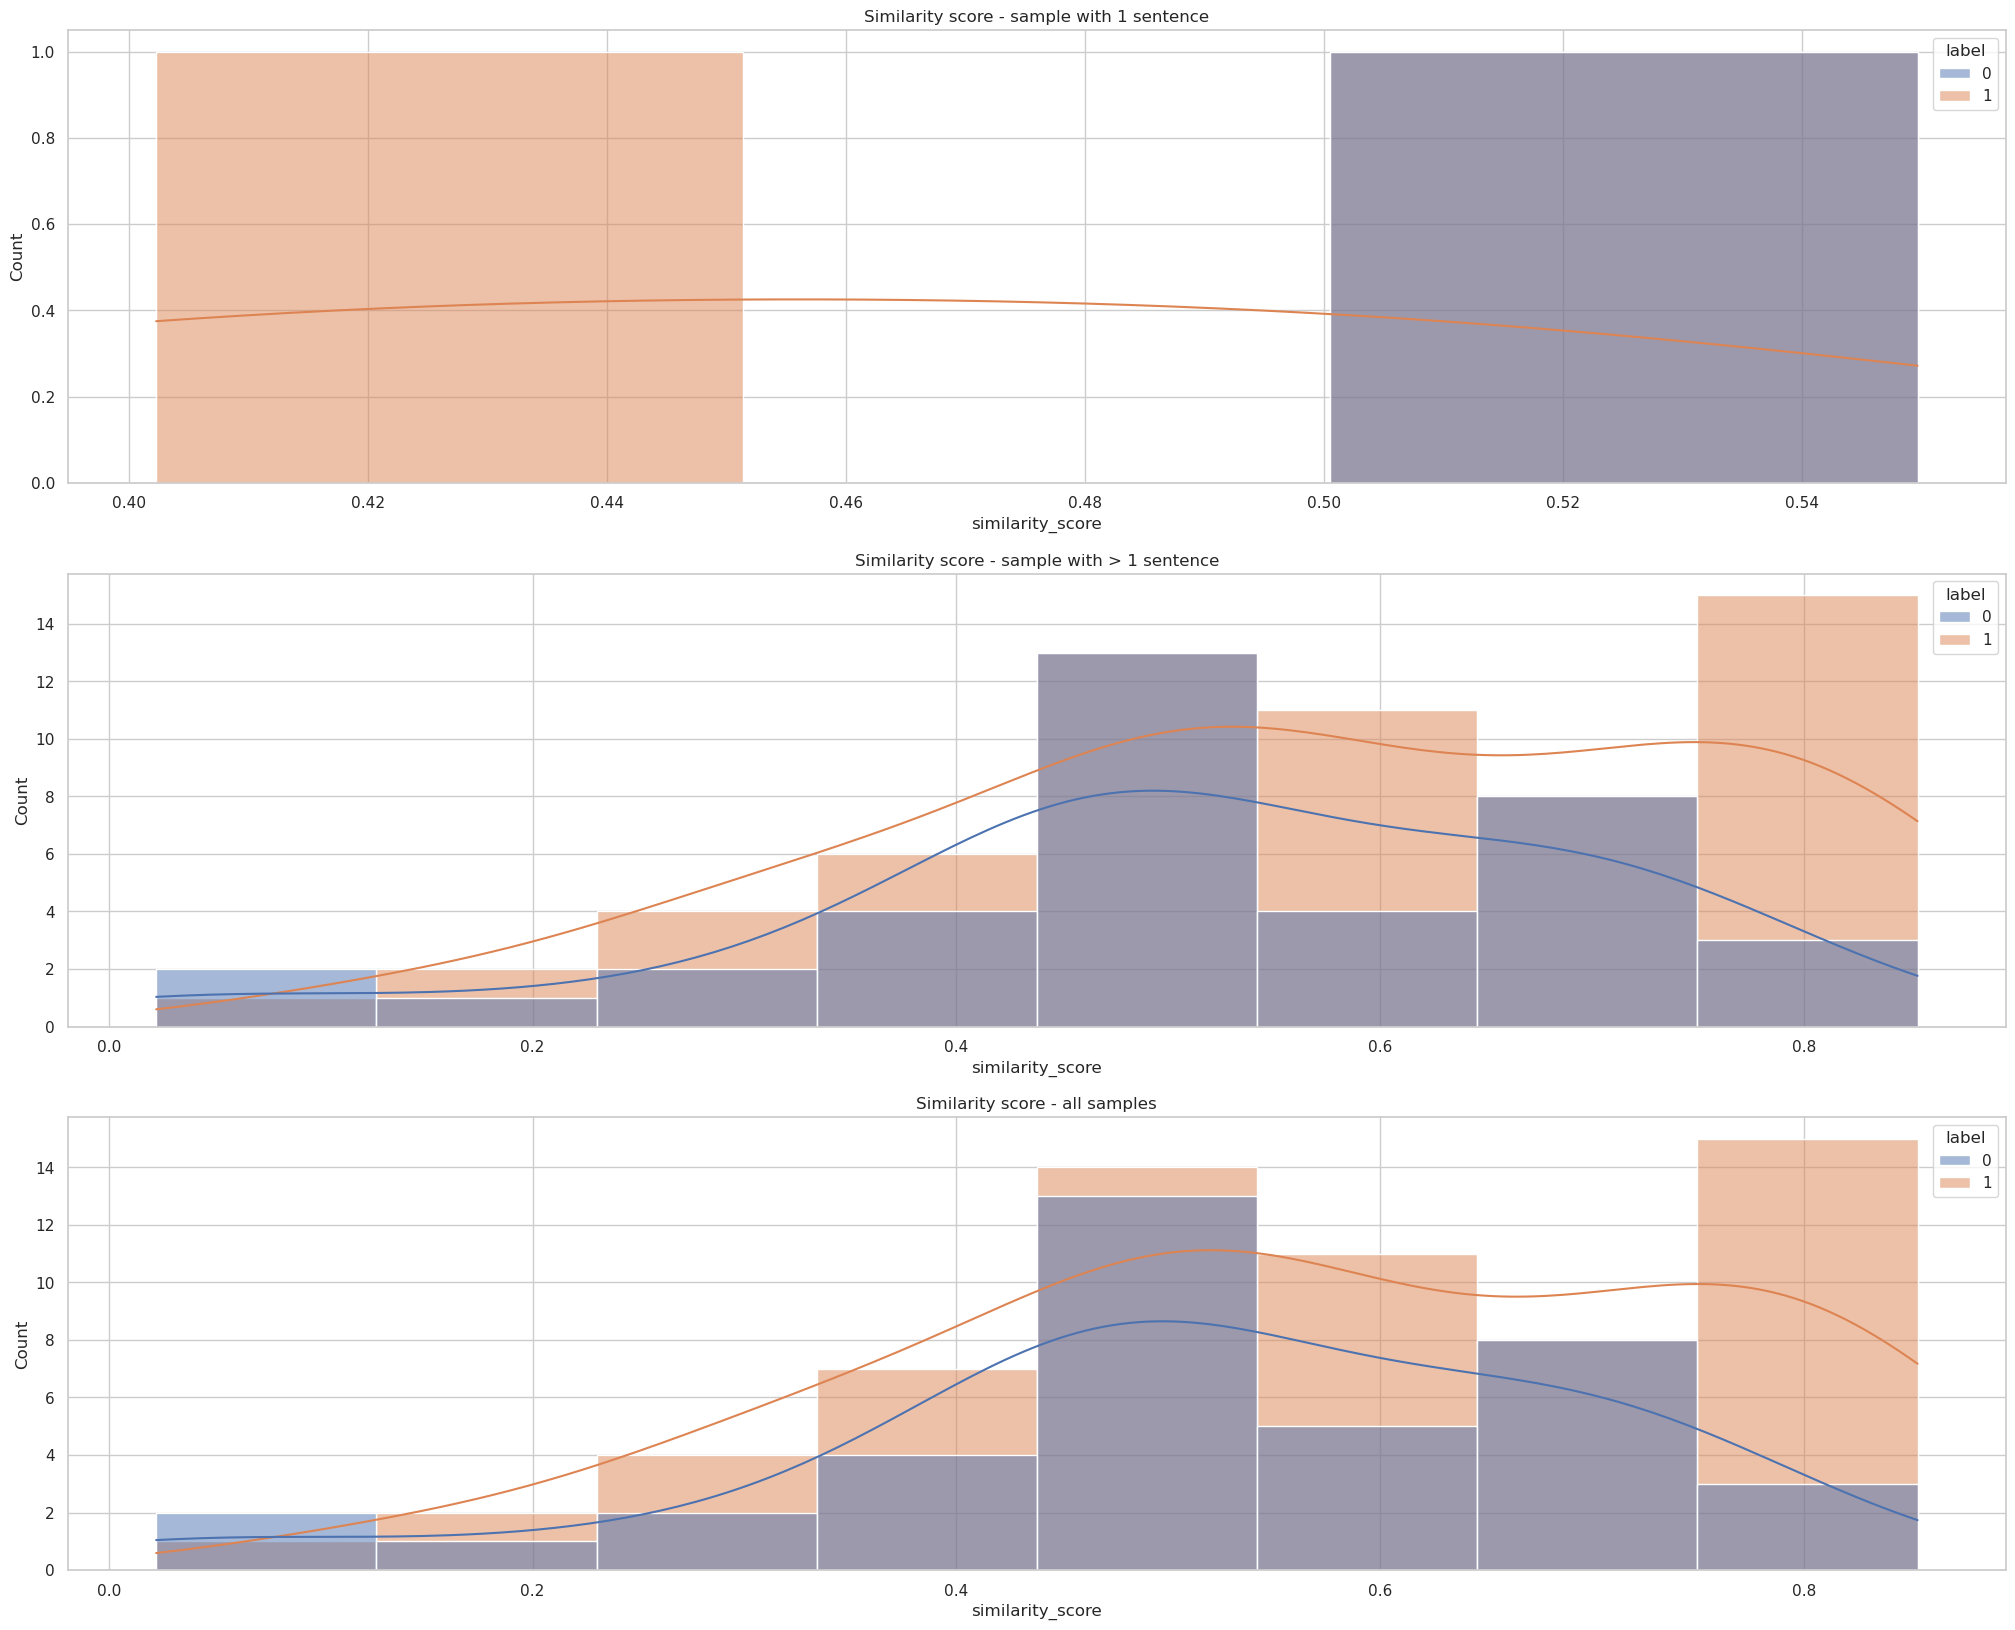

In [337]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(3, 1, figsize=(25, 20))
# plt.figure(figsize=(25, 10))

sns.histplot(df_en_train_small[df_en_train_small["no_of_sentences"] == 1], x='similarity_score', hue='label', kde=True, ax=ax[0])
sns.histplot(df_en_train_small[df_en_train_small["no_of_sentences"] > 1], x='similarity_score', hue='label', kde=True, ax=ax[1])
sns.histplot(df_en_train_small, x='similarity_score', hue='label', kde=True, ax=ax[2])

# sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[0][1])
# sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[0][2])

# sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[1][0])
# sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[1][1])
# sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[1][2])

ax[0].set_title("Similarity score - sample with 1 sentence")
ax[1].set_title("Similarity score - sample with > 1 sentence")
ax[2].set_title("Similarity score - all samples")

# ax[0][0].set_title('Train')
# ax[0][0].set_xlim(left=-50)
# ax[0][1].set_title('Dev')
# ax[0][1].set_xlim(left=-50)
# ax[0][2].set_title('Test')
# ax[0][2].set_xlim(left=-50)

# ax[1][0].set_title('Train')
# ax[1][0].set_xlim(left=-10, right=2500)
# ax[1][1].set_title('Dev')
# ax[1][1].set_xlim(left=-10, right=2500)
# ax[1][2].set_title('Test')
# ax[1][2].set_xlim(left=-10, right=2500)

plt.show()

# Use cosine similarity between each generated token embedding and original token embeddings

In [459]:
import torch.nn.functional as F
from nltk import word_tokenize, sent_tokenize


def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0), dim=-1).item()


def compute_average_token_similarities(original_token_embeddings, generated_token_embeddings):
    similarities = []
    for i in range(min(len(generated_token_embeddings), len(original_token_embeddings))):
        sim = cosine_similarity(generated_token_embeddings[i], original_token_embeddings[i])
        similarities.append(sim)
    
    # Print similarity scores for each token pair
    # print("Similarity per token:", similarities)
    
    # Optionally, you can average the similarity to get a single score
    average_similarity = sum(similarities) / len(similarities)
    # print("Average similarity:", average_similarity)

    return average_similarity


def generate_token_embeddings(model, tokenizer, context, original_text, generation_style="sentences", no_of_generated_sentences=2):
    model.eval()

    messages = []

    if generation_style == "sentences":
        messages = [
            {
                "role": "system",
                "content": f"You are an assistant and help people continue their stories with the most relevant information in the most natural way possible. You will have to respond with EXACTLY {no_of_generated_sentences} sentences."
            },
            {
                "role": "user",
                "content": f"Using only {no_of_generated_sentences} sentences continue this story in the most natural way possible: {context}"
            }
        ]
    elif generation_style == "words":
        messages = [
            {
                "role": "system",
                "content": f"You are an assistant and help people finish their sentences with the most relevant information in the most natural way possible. You should only complete the given sentence."
            },
            {
                "role": "user",
                "content": f"Finish this sentence in the most natural way possible: {context}"
            }
        ]
    else:
        raise Exception(f"No such generation_style = {generation_style}")

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        generated_outputs = model.generate(
            **model_inputs,
            max_new_tokens=1024,
        )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_outputs)
    ]
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # print(f"Generated text: {generated_text}")

    inputs = tokenizer([original_text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        # Get the hidden states for the input context
        original_outputs = model(**inputs, output_hidden_states=True)
        original_embeddings = original_outputs.hidden_states[-1]  # Take last hidden state
    
        # Get the hidden states for the entire sequence (input + generated)
        generated_outputs = model(generated_outputs, output_hidden_states=True)
        generated_embeddings = generated_outputs.hidden_states[-1]  # Take last hidden state
    
    generated_token_embeddings = generated_embeddings[0, len(inputs.input_ids[0]):, :]
    original_token_embeddings = original_embeddings[0, :, :]
    
    return original_token_embeddings, generated_token_embeddings


def generate_and_compute_token_embedding_similarity(model, tokenizer, text, no_of_sentences=2):
    sentences = sent_tokenize(text)

    n = len(sentences)

    similarity_score = None
    
    if n == 1:
        words = word_tokenize(sentences[0])

        # words_split = 2 * (len(words) // 3)
        words_split = len(words) // 2

        original_text = " ".join(words[words_split:])

        context = " ".join(words[:words_split])

        original_token_embeddings, generated_token_embeddings = generate_token_embeddings(
            model,
            tokenizer,
            context,
            original_text,
            generation_style="words",
        )

        similarity_score = compute_average_token_similarities(
            original_token_embeddings,
            generated_token_embeddings,
        )
    elif n == 2:
        original_text = sentences[1]

        context = sentences[0]

        original_token_embeddings, generated_token_embeddings = generate_token_embeddings(
            model,
            tokenizer,
            context,
            original_text,
            generation_style="sentences",
            no_of_generated_sentences=1,
        )

        similarity_score = compute_average_token_similarities(
            original_token_embeddings,
            generated_token_embeddings,
        )
    else:
        half = n // 2

        original_text = " ".join(sentences[half:])
        context = " ".join(sentences[:half])

        original_token_embeddings, generated_token_embeddings = generate_token_embeddings(
            model,
            tokenizer,
            context,
            original_text,
            generation_style="sentences",
            no_of_generated_sentences=max(8, half),
        )

        similarity_score = compute_average_token_similarities(
            original_token_embeddings,
            generated_token_embeddings,
        )
    
        # no_of_starting_sentences = 2
        # # generated_sentences = sentences[:no_of_starting_sentences]

        # total_similarity_score = 0.0
        # counter = 0
    
        # no_of_generated_sentences = min(no_of_sentences, n - no_of_starting_sentences)
        # for idx in range(no_of_starting_sentences, n, no_of_generated_sentences):
        #     original_text = " ".join(sentences[idx:idx + no_of_generated_sentences])

        #     # context = " ".join(generated_sentences[:idx])
        #     context = " ".join(sentences[:idx])
    
        #     ote, gte = generate_token_embeddings(
        #         model,
        #         tokenizer,
        #         context,
        #         original_text,
        #         generation_style="sentences",
        #         no_of_generated_sentences=no_of_generated_sentences,
        #     )

        #     total_similarity_score += compute_average_token_similarities(
        #         ote,
        #         gte,
        #     )
        #     counter += no_of_generated_sentences

        # similarity_score = total_similarity_score / counter

    return similarity_score

In [375]:
ote, gte = generate_token_embeddings(
    model,
    tokenizer,
    " ".join(human_train_sample_text_sentences[:-2]),
    human_train_sample_text_sentences[-2:]
)

print(ote.shape)
print(gte.shape)

Generated text: The Bush administration's decision to invade Iraq stemmed from concerns about Saddam Hussein's alleged possession of weapons of mass destruction, which the administration deemed a grave threat to international peace and security.
torch.Size([80, 896])
torch.Size([408, 896])


In [460]:
df_en_train_small = df_en_train.sample(100, random_state=RANDOM_SEED, ignore_index=True)

In [461]:
from tqdm import tqdm

tqdm.pandas()

df_en_train_small['similarity_score'] = df_en_train_small['text'].progress_apply(
    lambda text: generate_and_compute_token_embedding_similarity(
        model,
        tokenizer,
        text,
        no_of_sentences=1,
    )
)

100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


In [462]:
df_en_train_small["no_of_sentences"] = df_en_train_small["text"].map(lambda text: len(sent_tokenize(text)))

In [463]:
df_en_train_small

,id,source,sub_source,lang,model,label,text,similarity_score,no_of_sentences
0,71fee829-7871-4d08-9ca4-cb745808559e,mage,hswag,en,gpt-3.5-turbo,1,[Additional step] Slowly lift one foot off the...,0.369920,1
1,10ac6396-e03a-4a7e-a53c-a83df2b66f5f,m4gt,wikihow,en,davinci,1,Traveling without overpacking can seem like an...,0.547125,23
2,d3562b41-f80c-4036-ba45-c887574a8b68,m4gt,reddit,en,cohere,1,The abolishment of the Caliphate was a major e...,0.417041,15
3,98f6758e-41ce-4248-bb17-2b3f147c96d3,mage,squad,en,human,0,Beer ranges from less than 3 alcohol by volume...,0.507195,5
4,b6d1c774-5bf9-43a1-9271-81983ead5894,m4gt,wikipedia,en,bloomz,1,Institute of Eastern Europe (IEE) is the large...,0.434649,2
...,...,...,...,...,...,...,...,...,...
95,ad05076b-eef9-4f9a-881f-9c4fe985dd30,m4gt,reddit,en,human,0,Kind of general understanding is that if you w...,0.570415,12
96,84ce48d0-f693-47a2-b479-cd7e51e15150,m4gt,reddit,en,human,0,Iranian Politics are a bit complicated and con...,0.498692,19
97,c84db1fd-8acc-4ccc-8132-314a71213ba2,mage,cmv,en,flan_t5_small,1,Final Edit: Thank you to everyone who contribu...,0.214928,4
98,d1462304-e595-41e6-82fe-94d60d5e485d,m4gt,wikipedia,en,gemma-7b-it,1,## 1896 Boston Beaneaters Season\n\nThe 1896 B...,0.381427,19


In [464]:
df_en_train_small["label_based_on_similarity"] = df_en_train_small["similarity_score"].map(lambda score: 1 if score >0.4 else 0)

In [465]:
df_en_train_small

,id,source,sub_source,lang,model,label,text,similarity_score,no_of_sentences,label_based_on_similarity
0,71fee829-7871-4d08-9ca4-cb745808559e,mage,hswag,en,gpt-3.5-turbo,1,[Additional step] Slowly lift one foot off the...,0.369920,1,0
1,10ac6396-e03a-4a7e-a53c-a83df2b66f5f,m4gt,wikihow,en,davinci,1,Traveling without overpacking can seem like an...,0.547125,23,1
2,d3562b41-f80c-4036-ba45-c887574a8b68,m4gt,reddit,en,cohere,1,The abolishment of the Caliphate was a major e...,0.417041,15,1
3,98f6758e-41ce-4248-bb17-2b3f147c96d3,mage,squad,en,human,0,Beer ranges from less than 3 alcohol by volume...,0.507195,5,1
4,b6d1c774-5bf9-43a1-9271-81983ead5894,m4gt,wikipedia,en,bloomz,1,Institute of Eastern Europe (IEE) is the large...,0.434649,2,1
...,...,...,...,...,...,...,...,...,...,...
95,ad05076b-eef9-4f9a-881f-9c4fe985dd30,m4gt,reddit,en,human,0,Kind of general understanding is that if you w...,0.570415,12,1
96,84ce48d0-f693-47a2-b479-cd7e51e15150,m4gt,reddit,en,human,0,Iranian Politics are a bit complicated and con...,0.498692,19,1
97,c84db1fd-8acc-4ccc-8132-314a71213ba2,mage,cmv,en,flan_t5_small,1,Final Edit: Thank you to everyone who contribu...,0.214928,4,0
98,d1462304-e595-41e6-82fe-94d60d5e485d,m4gt,wikipedia,en,gemma-7b-it,1,## 1896 Boston Beaneaters Season\n\nThe 1896 B...,0.381427,19,0


In [466]:
# predictions = df_en_train_small[df_en_train_small["no_of_sentences"] == 1]["label_based_on_similarity"].tolist()
# labels = df_en_train_small[df_en_train_small["no_of_sentences"] == 1]["label"].tolist()

# predictions = df_en_train_small[df_en_train_small["no_of_sentences"] > 1]["label_based_on_similarity"].tolist()
# labels = df_en_train_small[df_en_train_small["no_of_sentences"] > 1]["label"].tolist()

predictions = df_en_train_small["label_based_on_similarity"].tolist()
labels = df_en_train_small["label"].tolist()

macro_f1 = f1_score(predictions, labels, average='macro')
accuracy = accuracy_score(predictions,labels)
balanced_accuracy = balanced_accuracy_score(predictions, labels)

print(f"F1: {macro_f1}")
print(f"Accuracy: {accuracy}")
print(f"Balanced accuracy: {balanced_accuracy}")

F1: 0.43502824858757067
Accuracy: 0.53
Balanced accuracy: 0.44032549728752257


/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

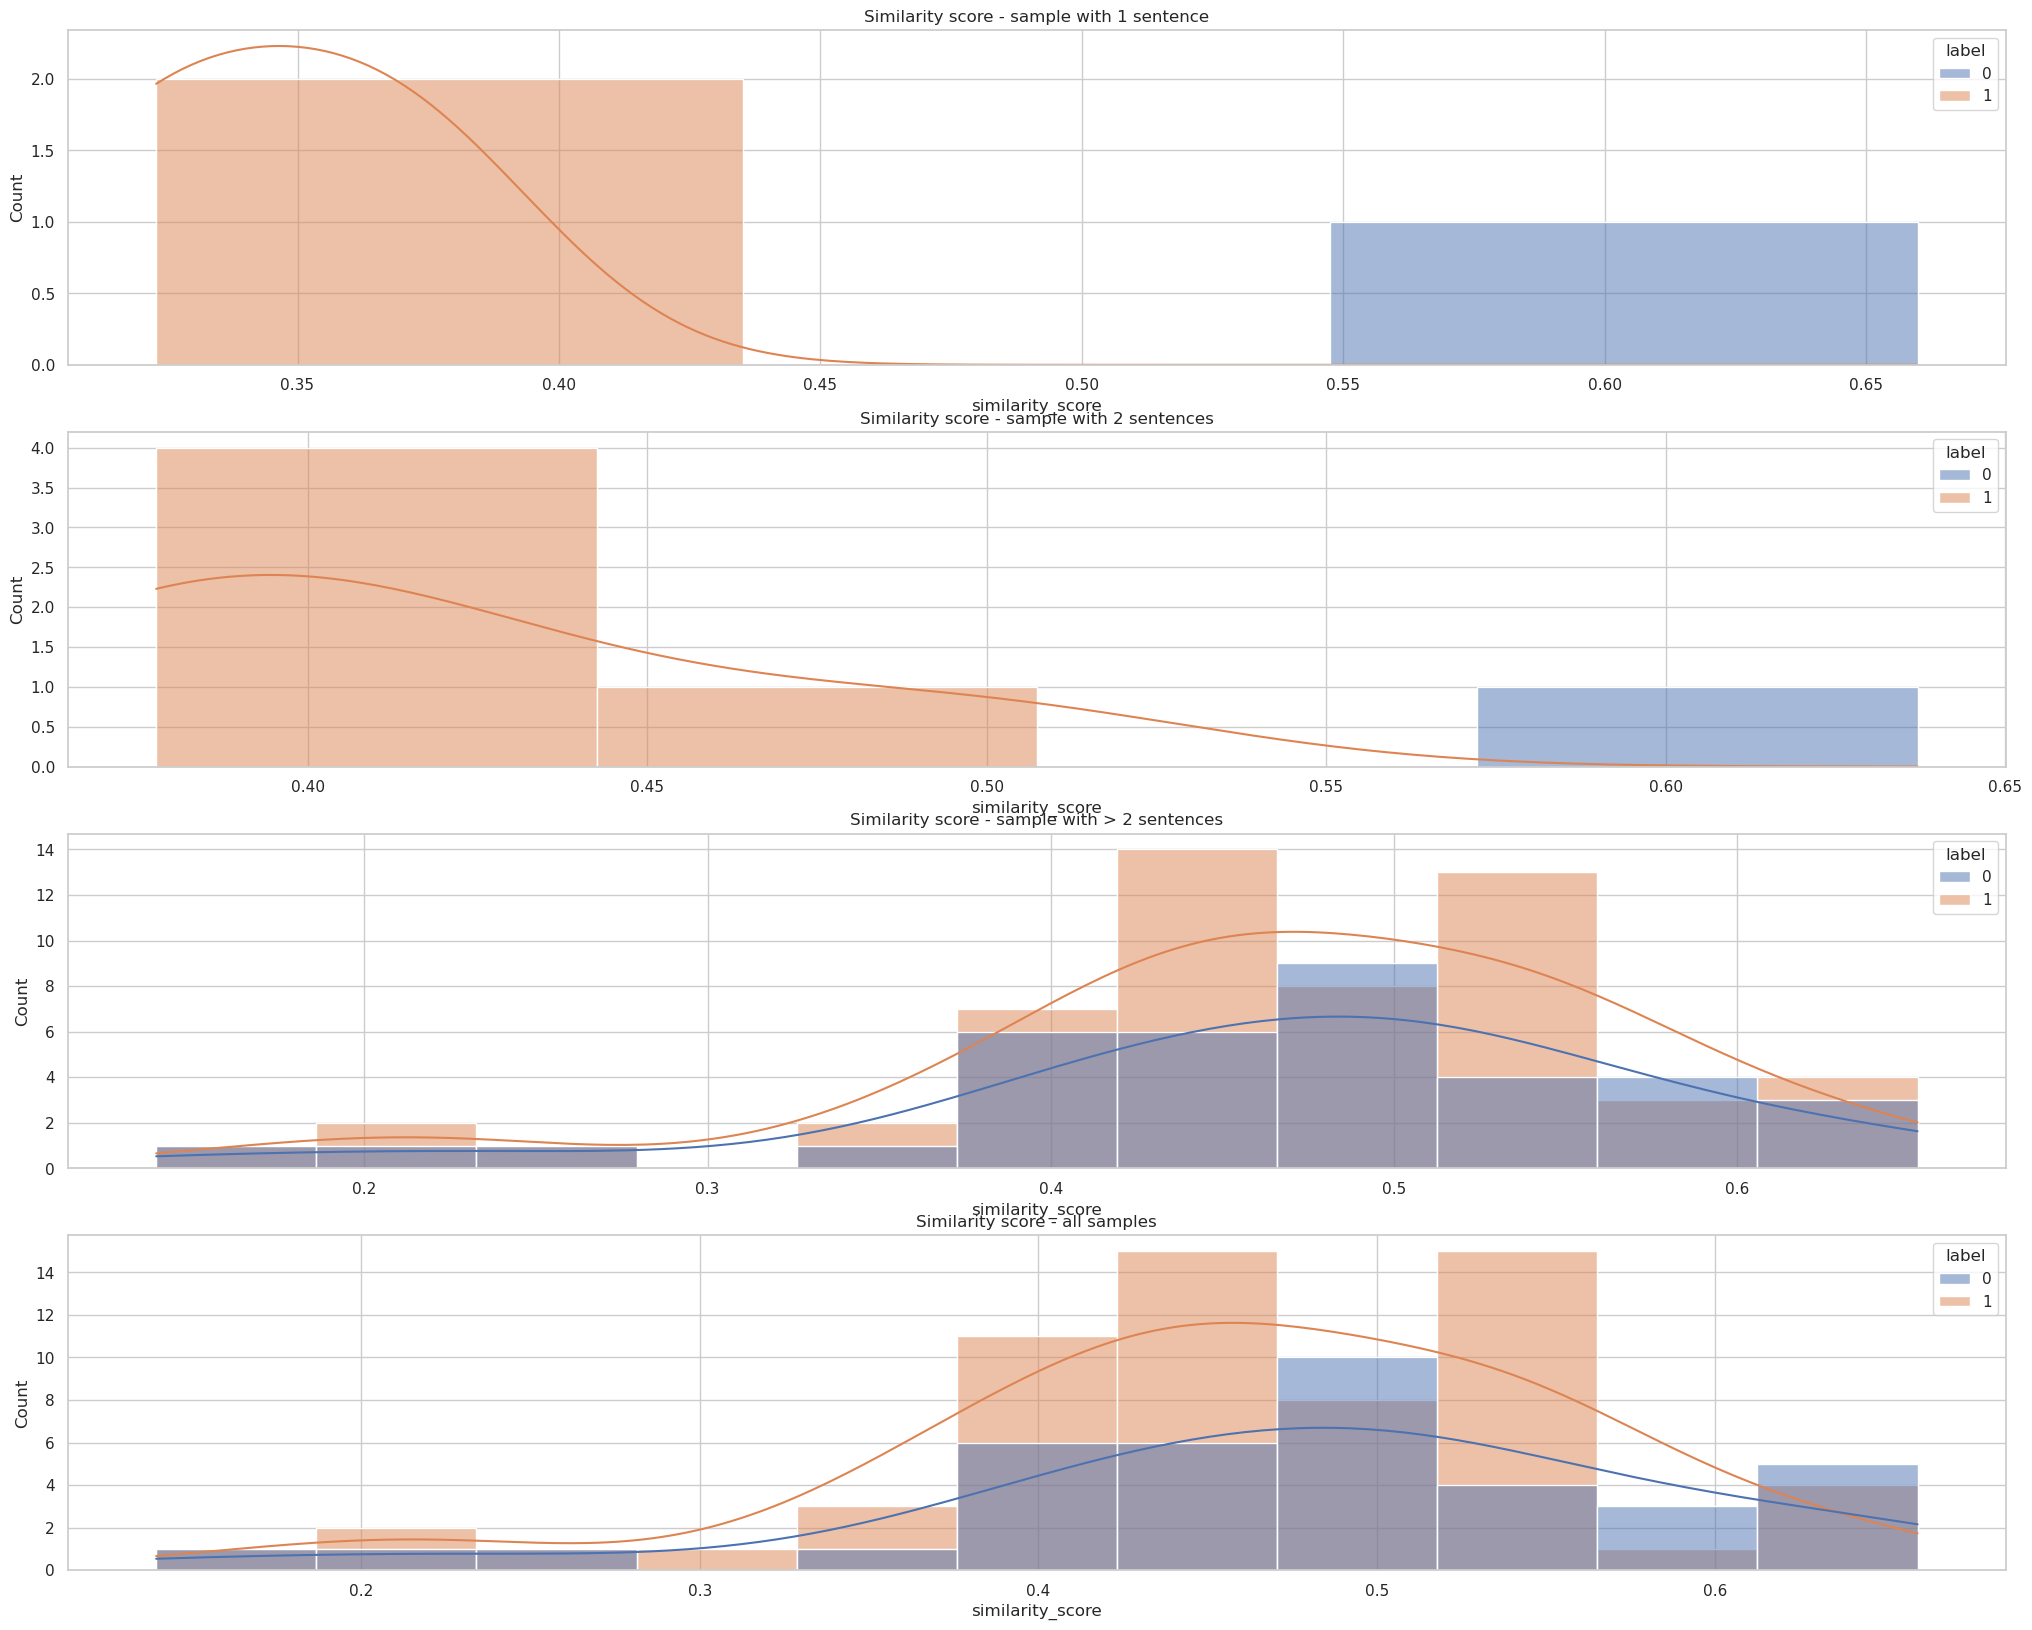

In [467]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(4, 1, figsize=(25, 20))
# plt.figure(figsize=(25, 10))

sns.histplot(df_en_train_small[df_en_train_small["no_of_sentences"] == 1], x='similarity_score', hue='label', kde=True, ax=ax[0])
sns.histplot(df_en_train_small[df_en_train_small["no_of_sentences"] == 2], x='similarity_score', hue='label', kde=True, ax=ax[1])
sns.histplot(df_en_train_small[df_en_train_small["no_of_sentences"] > 2], x='similarity_score', hue='label', kde=True, ax=ax[2])
sns.histplot(df_en_train_small, x='similarity_score', hue='label', kde=True, ax=ax[3])

ax[0].set_title("Similarity score - sample with 1 sentence")
ax[1].set_title("Similarity score - sample with 2 sentences")
ax[2].set_title("Similarity score - sample with > 2 sentences")
ax[3].set_title("Similarity score - all samples")

plt.show()

# Measure performance before training/fine-tuning the model

In [ ]:
import torch

from tqdm import tqdm


def get_performance_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return {
        'f1': f1,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'classification_report': cr
    }


def measure_initial_performance(model, tokenizer, df_test, device, max_length=512, batch_size=64):
    model.to(device)
    model.eval()

    test_samples = df_test.text.tolist()

    outputs = []
    for i in tqdm(range(0, len(test_samples), batch_size)):
        batch = test_samples[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            outputs.append(output.logits)

    outputs = torch.cat(outputs, dim=0)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    performance = get_performance_metrics(df_test.label, predictions)
    return performance


initial_performance = measure_initial_performance(model, tokenizer, df_en_dev, DEVICE)
initial_performance

In [11]:
def test_samples(model, tokenizer, df, device, max_length=512):
    model.to(device)
    model.eval()

    test_samples = df.text.tolist()[:5]
    inputs = tokenizer(
        test_samples,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits

    # print(outputs.shape)
    print(outputs)

In [12]:
test_samples(model, tokenizer, df_en_train, DEVICE)

tensor([[-0.0314,  0.0181],
        [-0.0319,  0.0190],
        [-0.0338,  0.0227],
        [-0.0318,  0.0197],
        [-0.0323,  0.0195]], device='cuda:0')


# Fine-tune the model

In [16]:
class_weights = (
    1 / df_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()

class_weights

tensor([0.6252, 0.3748])

In [17]:
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(df_en_train)
ds_dev = Dataset.from_pandas(df_en_dev)
ds_test = Dataset.from_pandas(df_en_test)

/root/.conda/envs/pytorch/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [18]:
ds_train

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 610767
})

In [19]:
ds_train_shuffled = ds_train.shuffle(seed=RANDOM_SEED)

In [20]:
dataset = DatasetDict({
    'train': ds_train_shuffled,
    'dev': ds_dev,
    'test': ds_test
})

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text'],
        num_rows: 32557
    })
})

In [22]:
MAX_LEN = 2048
# col_to_delete = ['source', 'sub_source', 'lang', 'model']


def preprocess_dataset(ds):
    return tokenizer(ds['text'], truncation=True, max_length=MAX_LEN)


tokenized_datasets = dataset.map(preprocess_dataset, batched=True)
tokenized_datasets.set_format("torch")
     

Map:   0%|          | 0/610767 [00:00<?, ? examples/s]

Map:   0%|          | 0/261758 [00:00<?, ? examples/s]

Map:   0%|          | 0/32557 [00:00<?, ? examples/s]

In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text', 'input_ids', 'attention_mask'],
        num_rows: 32557
    })
})

In [24]:
from transformers import DataCollatorWithPadding

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }

In [26]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [31]:
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

# experiment = Experiment(
#     api_key=comet_api_key,
#     project_name="mgt-detection-coling-2025",
#     workspace="unibuc-phd",
# )

In [30]:
params = {
    "learning_rate": 2e-4,
    "num_train_epochs": 2,
    "weight_decay": 1e-2,
    "batch_size": 32,
    "seed": RANDOM_SEED,
}

# experiment.log_parameters(params)

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f'../results/subtask_a/{MODEL_NAME}/002',
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    # report_to="comet_ml",
    seed=params["seed"],
)

comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


In [32]:
trainer = WeightedCrossEntropyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_142982/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [33]:
train_result = trainer.train()

[2024-10-06 22:41:26,211] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teodormarchitan (unibuc-nlp). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.107300,0.098656,0.957111,0.959470,0.954120
2,0.062900,0.082588,0.967969,0.969858,0.966588


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [34]:
metrics = train_result.metrics
max_train_samples = len(ds_train)
metrics["train_samples"] = min(max_train_samples, len(ds_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          2.0
  total_flos               = 3770552995GF
  train_loss               =       0.1097
  train_runtime            =  16:19:10.79
  train_samples            =       610767
  train_samples_per_second =       20.792
  train_steps_per_second   =        0.325


In [35]:
trainer.save_model(f"../results/subtask_a/{MODEL_NAME}/002/fine-tuned-model")

In [36]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [37]:
df_test_predictions = make_predictions(
    trainer.model,
    tokenizer,
    df_en_test,
    DEVICE,
    f"../results/subtask_a/{MODEL_NAME}/002/subtask_a.jsonl",
)

100%|██████████| 1018/1018 [24:16<00:00,  1.43s/it]


In [38]:
df_en_train.label.value_counts(normalize=True)

label
1    0.625189
0    0.374811
Name: proportion, dtype: float64

In [39]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.636453
0    0.363547
Name: proportion, dtype: float64

In [40]:
import json

with open(f"../results/subtask_a/{MODEL_NAME}/002/config.json", "w") as f:
    json.dump(params, f)

In [38]:
# experiment.end()